### Maxcut Runtime

### Preparing Execution

In [1]:
import subprocess
import uuid

# Runs shell script that creates maxcut_runtime.py
subprocess.run(['sh', './sh_script.sh'])

# Defining input parameters
min_qubits=4
max_qubits=8
max_circuits=1
num_shots=5000

backend_id="ibmq_qasm_simulator"
hub="ibm-q"; group="open"; project="main"
exec_options = None

# Meta data required by qiskit runtime
meta = {
  "name": f"qedc-maxcut-benchmark-{uuid.uuid4()}",
  "description": "A sample Maxcut Benchmark program.",
  "max_execution_time": 100000,
  "version": "1.0",
}

API_TOKEN = "your_api_token"

### Executing benchmark on Runtime Servers

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import IBMQ
import json

import traceback
import os

try:
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub=hub, group=group, project=project)

    service = QiskitRuntimeService(
        channel='ibm_quantum',
        token=API_TOKEN
    )

    program_id = service.upload_program(data='maxcut_runtime.py', metadata=meta)

    options = {
        'backend_name': backend_id
    }

    with open(os.path.join("..", "_common", "instances.json"), "r") as file:
        insts = json.load(file)

    runtime_inputs = {
        "backend_id": backend_id,
        "method": 2,
        "_instances": insts,
        "min_qubits": min_qubits,
        "max_qubits": max_qubits,
        "max_circuits": max_circuits,
        "num_shots": num_shots
    }

    job = service.run(
        program_id=program_id,
        options=options,
        inputs=runtime_inputs,
        instance='ibm-q-research/quantum-circ-1/main'
    )

    # Get results
    result = job.result()
    result["meta"] = {
        "creation_date": job.creation_date.ctime(),
        "job_id": job.job_id,
        "program_id": job.program_id,
    }

    with open("results.json", "w+") as file:
        json.dump(result, file)

    subprocess.run(['rm', 'maxcut_runtime.py'])
except Exception as e:
    print(f'The Exception {e} has occurred!')
    # Prints full traceback for easier debugging
    print(traceback.format_exc())

finally:
    service.delete_program(program_id)
    IBMQ.disable_account()

In [3]:
import json
import sys

sys.path[1:1] = [ "../../_common", "../../_common/qiskit", "../../maxcut/_common/" ]
import metrics as metrics

def external_init(res_dict):
	metrics.init_metrics()
	metrics.circuit_metrics = res_dict['circuit_metrics_detail']
	metrics.circuit_metrics_detail_2 = res_dict['circuit_metrics_detail_2']
	metrics.circuit_metrics_final_iter = res_dict['circuit_metrics_final_iter']
	method = res_dict['benchmark_inputs']['method']
	metrics.circuit_metrics['subtitle'] = f"Benchmark Results - MaxCut ({method}) - Qiskit"

def plt_from_data(res_dict):
	inputs = res_dict.get('benchmark_inputs', {})
	if not inputs: raise Exception('No Inputs Found')
	external_init(res_dict)
	method = inputs['method']
	area_metrics = [
		'score_metric',
		'x_metric',
		'y_metric',
		'x_size',
		'y_size',
	]
	option_keys = [
		'num_shots',
		'rounds',
		'degree',
		'objective_func_type'
	]
	for_area_metrics = {metric: inputs[metric] for metric in area_metrics}
	
	suffix = inputs['objective_func_type']
			
	# obj_str = metrics.known_score_labels['objective_func_type']
	options = {option: inputs[option] for option in option_keys}

	metrics.plot_all_area_metrics(
		f"Benchmark Results - MaxCut ({method}) - Qiskit",
		options=options,
		suffix=suffix,
		**for_area_metrics
	)

	metrics.plot_metrics_optgaps(f"Benchmark Results - MaxCut ({method}) - Qiskit",
									options=options,
									suffix=suffix, objective_func_type = suffix)

	metrics.plot_ECDF(suptitle=f"Benchmark Results - MaxCut ({method}) - Qiskit",
									options=options, suffix=suffix)

	all_widths = list(metrics.circuit_metrics_final_iter.keys())
	all_widths = [int(ii) for ii in all_widths]
	list_of_widths = [all_widths[-1]]
	metrics.plot_cutsize_distribution(suptitle=f"Benchmark Results - MaxCut ({method}) - Qiskit",
									options=options, suffix=suffix, list_of_widths = list_of_widths)



... execution starting at Aug 11, 2022 23:29:11 UTC

Benchmark Results - MaxCut (2) - Qiskit
     ****** NO RESULTS ****** 


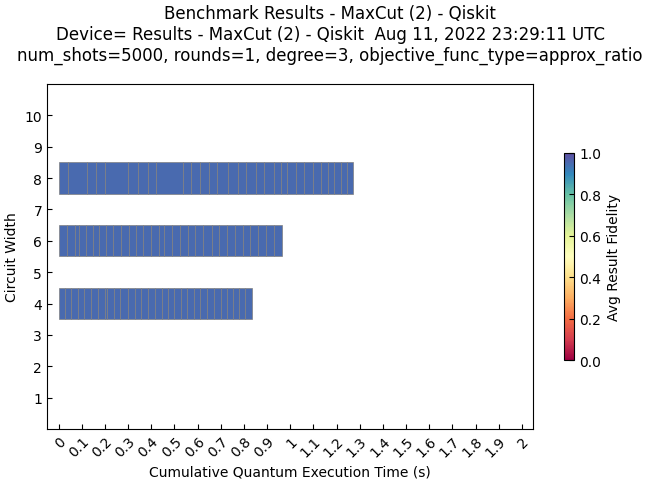

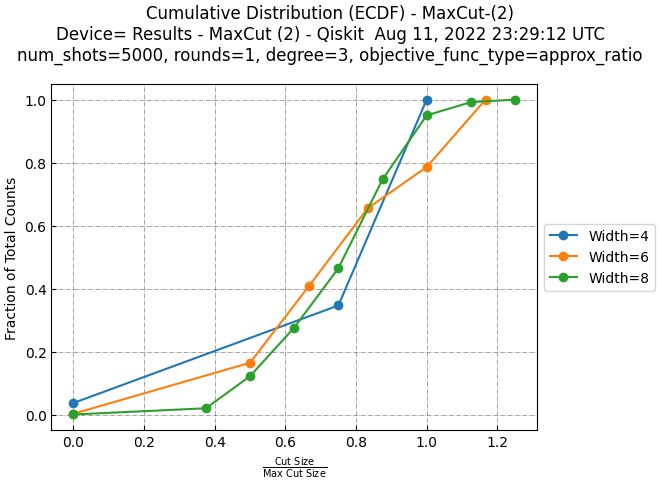

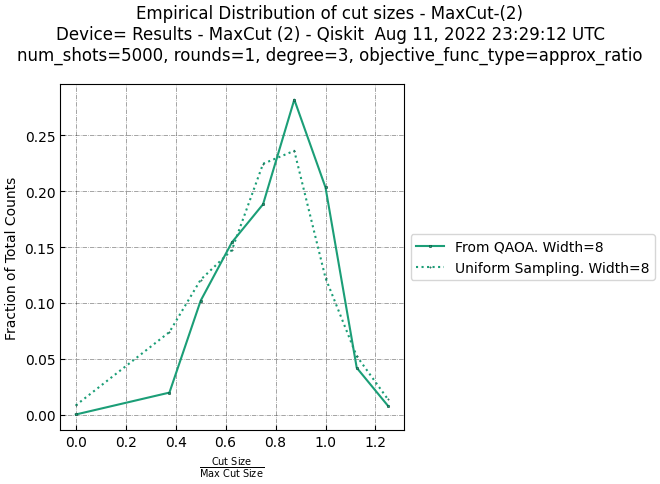

In [5]:
with open("results.json", "r") as file:
    result = json.load(file)
plt_from_data(result)